In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import palettable
import itertools
import geopandas as gpd
import shapely.geometry as geo
from tqdm import tqdm_notebook
from matplotlib import colors
%matplotlib inline

In [3]:
MZ_REFERENCE_PATH = "/run/media/sebastian/shoerl_data/astra1802/analysis/reference"
DATA_PATH = "/run/media/sebastian/shoerl_data/astra1802/analysis/25pct"
SCENARIO_SHAPEFILE_PATH = "/home/sebastian/astra/astra_2018_002/gis/scenarios/scenarios.shp"

In [4]:
columns = [
    "person_id", "trip_id", "departure_time", "arrival_time", 
    "mode", "purpose", 
    "origin_x", "origin_y", "destination_x", "destination_y",
    "crowfly_distance", "network_distance",
     "case", "weight", "mode_detailed"
]

df_persons = pd.read_csv("%s/persons.csv" % MZ_REFERENCE_PATH, sep = ";")
df_persons = df_persons[["person_id", "person_weight"]]

df_reference = pd.read_csv("%s/trips.csv" % MZ_REFERENCE_PATH, sep = ";")
df_reference = pd.merge(df_reference, df_persons, on = "person_id")

df_reference["case"] = "MZ2015"
df_reference["weight"] = df_reference["person_weight"]
df_reference = df_reference[columns]

def load_simulation(path, case):
    df_simulation = pd.read_csv(path, sep = ";")
    df_simulation = df_simulation.rename({ "person_trip_id" : "trip_id", "start_time" : "departure_time" }, axis = 1)
    df_simulation["arrival_time"] = df_simulation["departure_time"] + df_simulation["travel_time"]
    df_simulation["purpose"] = df_simulation["followingPurpose"]
    df_simulation["case"] = case
    df_simulation["weight"] = 1.0
    df_simulation["crowfly_distance"] *= 1000
    df_simulation["network_distance"] *= 1000
    df_simulation["mode_detailed"] = df_simulation["mode"]
    df_simulation = df_simulation[columns]
    return df_simulation

df = pd.concat([
    load_simulation("%s/bl_2020_25pct.trips.csv" % DATA_PATH, "Simulation"),
    df_reference
])

df["travel_time"] = df["arrival_time"] - df["departure_time"]

df["mode_agg"] = df["mode"]
df["mode_agg"] = df["mode_agg"].replace({ "walk" : "slow", "bike" : "slow" })

df["mode_detailed"] = df["mode_detailed"].replace({ "plane" : "pt", "taxi" : "pt" })
df = df[df["crowfly_distance"] > 0]

In [4]:
df_shapes = gpd.read_file(SCENARIO_SHAPEFILE_PATH)
df_shapes.crs = {"init": "EPSG:2056"}
df_shapes["scenario"] = df_shapes["scenario"].astype("category")

df_od = pd.DataFrame(df[["person_id", "trip_id", "case", "origin_x", "destination_x", "origin_y", "destination_y"]], copy = True)
df_od["origin_geometry"] = [geo.Point(*xy) for xy in tqdm_notebook(zip(df_od["origin_x"], df_od["origin_y"]), total = len(df))]
df_od["destination_geometry"] = [geo.Point(*xy) for xy in tqdm_notebook(zip(df_od["destination_x"], df_od["destination_y"]), total = len(df))]
df_od = gpd.GeoDataFrame(df_od, crs = {"init": "EPSG:2056"})

df_od = df_od.set_geometry("origin_geometry")
df_od = gpd.sjoin(df_od, df_shapes.rename({"scenario": "origin_scenario"}, axis = 1), op = "within")
del df_od["index_right"]

df_od = df_od.set_geometry("destination_geometry")
df_od = gpd.sjoin(df_od, df_shapes.rename({"scenario": "destination_scenario"}, axis = 1), op = "within")
del df_od["index_right"]

df_od = df_od[["person_id", "trip_id", "case", "origin_scenario", "destination_scenario"]]
df = pd.merge(df, df_od, how = "left", on = ["person_id", "trip_id", "case"])

In [5]:
bellevue = (2683253.0, 1246745.0)

origin_bellevue_distance = np.sqrt((df["origin_x"] - bellevue[0])**2 + (df["origin_y"] - bellevue[1])**2)
destination_bellevue_distance = np.sqrt((df["destination_x"] - bellevue[0])**2 + (df["destination_y"] - bellevue[1])**2)

f_zh30 = (origin_bellevue_distance < 30 * 1e3) & (destination_bellevue_distance < 30 * 1e3)
f_all = np.ones((len(df), ), dtype = np.bool)

In [9]:
scenarios = [f_zh30, f_all]
titles = ["Zurich", "Switzerland"]
maximum_distances = [20, 100]

scenarios = [f_all]
titles = ["Switzerland"]
maximum_distances = [40]

In [7]:
f_lu = (df["origin_scenario"] == "lu") & (df["destination_scenario"] == "lu")
f_lg = (df["origin_scenario"] == "lg") & (df["destination_scenario"] == "lg")
f_sa = (df["origin_scenario"] == "sa") & (df["destination_scenario"] == "sa")

scenarios = [f_all, f_lu, f_lg, f_sa]
titles = ["Switzerland", "Rural Undirected", "Rural Directed", "Urban + Agglomeration"]
maximum_distances = [40, 10, 10, 10]

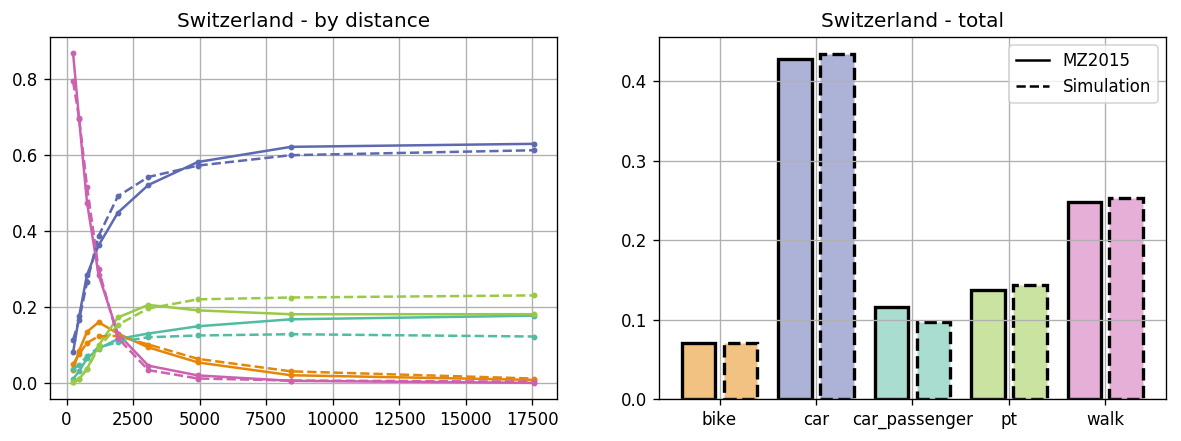

In [15]:
plt.figure(dpi = 120, figsize = (12, 4 * len(scenarios)))

for i_scenario, (f_scenario, title, maximum_distance) in enumerate(zip(scenarios, titles, maximum_distances)):
    plt.subplot(len(scenarios), 2, i_scenario * 2 + 1)

    distance_slot = "crowfly_distance"
    mode_slot = "mode_detailed"
    modes = sorted(df[mode_slot].unique())
    modes.remove("truck")
    cases = sorted(df["case"].unique())

    #bounds = np.linspace(0, 15, 20)[1:] * 1000.0
    #distance_filters = [df[distance_slot] <= b for b in bounds]
    
    # (df[distance_slot] <= maximum_distance)
    distances = df.loc[(df["case"] == "MZ2015") & f_scenario, distance_slot]
    quantiles = [distances.quantile(q / 10) for q in range(10)]
    bounds = quantiles

    #bounds = np.linspace(0, maximum_distance, 10) * 1000.0
    distance_filters = [(df[distance_slot] > lb) & (df[distance_slot] <= ub) for lb, ub in zip(bounds, bounds[1:])]
    bounds = bounds[1:]

    mode_filters = [df[mode_slot] == m for m in modes]
    case_filters = [df["case"] == c for c in cases]

    case_styles = ["-", "--", ":"]
    mode_colors = ["C0", "C1", "C2", "C3", "C4"]
    
    mode_count = 5
    mode_colors = [[0.9 * (k+1) / mode_count] * 3 for k in range(mode_count)]
    
    mode_colors = palettable.cartocolors.qualitative.Vivid_5.mpl_colors

    for f_case, case_style in zip(case_filters, case_styles):
        totals = np.array([df[f_case & f_scenario & f]["weight"].sum() for f in distance_filters])

        for f_mode, mode_color in zip(mode_filters, mode_colors):
            values = np.array([df[f_mode & f_case & f_scenario & f]["weight"].sum() for f in distance_filters])
            plt.plot(bounds, values / totals, color = mode_color, linestyle = case_style, marker = ".", markersize = 5)

    for mode, mode_color in zip(modes, mode_colors):
        plt.plot(np.nan, np.nan, color = mode_color, label = mode)

    for case, case_style in zip(cases, case_styles):
        plt.plot(np.nan, np.nan, linestyle = case_style, label = case, color = "k")

    #plt.legend(loc = "best", ncol = 3)
    plt.grid()
    plt.title(title + " - by distance")

    plt.subplot(len(scenarios), 2, i_scenario * 2 + 2)

    bar_padding = 0.2
    bar_width = 1.0 - bar_padding
    mode_padding = 0.3

    for i_case, (f_case, case_style) in enumerate(zip(case_filters, case_styles)):
        counts = np.array([df[f_case & f_mode & f_scenario]["weight"].sum() for f_mode in mode_filters])
        counts /= np.sum(counts)

        for i_mode, mode_color in enumerate(mode_colors):
            index = i_mode * len(case_filters) + i_case
            x = index + 0.5 * bar_padding + i_mode * mode_padding
            color = tuple(list(colors.to_rgb(mode_color)) + [0.5])
            plt.bar([x], counts[i_mode], color = color, edgecolor = "k", width = bar_width, linewidth = 2, linestyle = case_style, align = "edge")

    x = (len(case_filters) + mode_padding) * np.arange(0, 100) + 0.5 * len(case_filters)
    plt.gca().xaxis.set_major_locator(tck.FixedLocator(x))
    plt.gca().xaxis.set_major_formatter(tck.FixedFormatter(modes))

    for case, case_style in zip(cases, case_styles):
        plt.plot(np.nan, np.nan, linestyle = case_style, label = case, color = "k")

    plt.legend(loc = "best")
    plt.title(title + " - total")
    plt.grid()

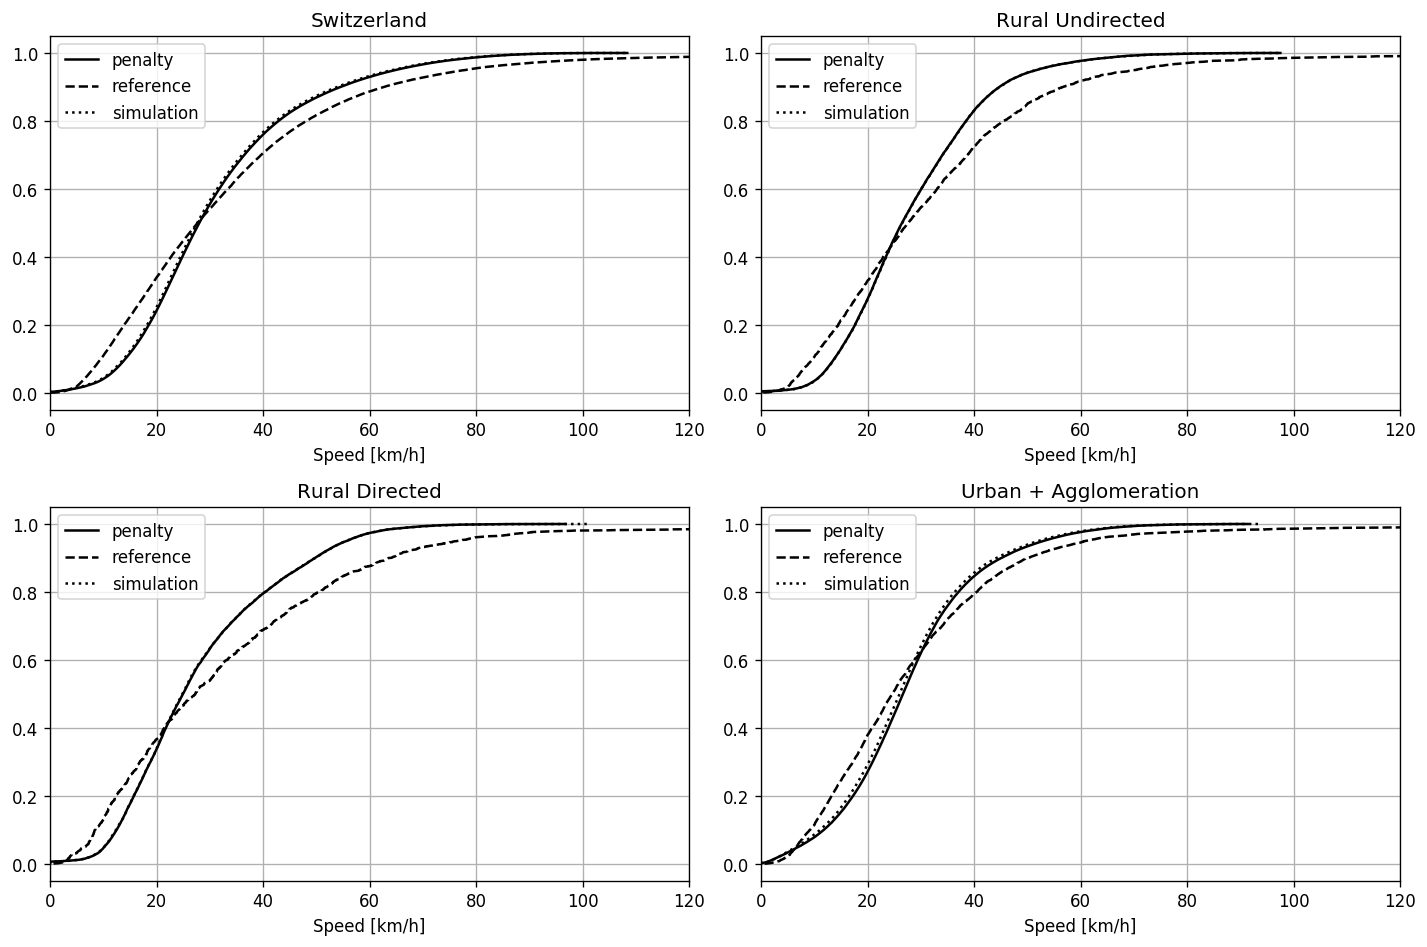

In [9]:
df["speed"] = df["network_distance"] / df["travel_time"] * (3600 / 1000)
f_car = df["mode"] == "car"

rows = len(scenarios) // 2 if len(scenarios) % 2 == 0 else (len(scenarios) // 2) + 1
cols = 2

plt.figure(dpi = 120, figsize = (12, 4 * rows))

for i_scenario, (f_scenario, title, maximum_distance) in enumerate(zip(scenarios, titles, maximum_distances)):
    plt.subplot(rows, cols, i_scenario + 1)
    
    for i_case, (f_case, case_style) in enumerate(zip(case_filters, case_styles)):
        values = df[f_case & f_scenario & f_car]["speed"].values
        plt.plot(np.sort(values), np.arange(len(values)) / (len(values) + 1), linestyle = case_style, color = "k")
        
    for case, case_style in zip(cases, case_styles):
        plt.plot(np.nan, np.nan, linestyle = case_style, label = case, color = "k")
    
    plt.xlabel("Speed [km/h]")
    plt.legend(loc = "best")
    plt.title(title)
    plt.xlim([0, 120])
    plt.grid()

plt.tight_layout()